# 📈 Viability Check — Olist (Churn vs. Segunda Compra)

Este cuaderno evalúa **si el dataset Olist sirve para churn** y, si no, qué tan **viable** es tratarlo como **propensión a segunda compra** en un horizonte `H_DAYS`.

**Puntos clave del análisis:**
- Porcentaje de clientes con **≥ 2 compras** (señal mínima para aprender recompra).
- **Censura temporal**: pedidos demasiado cerca del final del periodo que impiden etiquetar bien.
- **Prevalencia** de la clase objetivo y **baseline** de PR-AUC (azar).
- Cotas simples para **Precision@k** y **Lift@k** en el mejor de los casos.

> **Nota:** No se usan variables con **fuga temporal**. Solo fechas de compra.

In [9]:
# Parámetros
H_DAYS = 180              # Horizonte para recompra/churn
DELIVERED_ONLY = False    # Si True, filtra a pedidos entregados

import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 120)

### 🔎 Carga de datos (auto-detector de rutas)

Busca archivos típicos dentro de `./data` y subcarpetas. Si no los encuentra, ajusta las rutas manualmente.

In [10]:
def _find_csv(patterns, roots=(".", "./data", "./data/raw", "../data", "../data/raw")):
    cand = []
    for root in roots:
        for pat in patterns:
            cand.extend(glob.glob(os.path.join(root, "**", pat), recursive=True))
    # Prioriza rutas con 'olist_' y 'dataset'
    cand = sorted(cand, key=lambda p: (("olist_" not in os.path.basename(p)) , len(p)))
    return cand[0] if cand else None

CUSTOMERS_CSV = _find_csv(["*customers*.csv"])
ORDERS_CSV    = _find_csv(["*orders*.csv"])

print("CUSTOMERS_CSV:", CUSTOMERS_CSV)
print("ORDERS_CSV   :", ORDERS_CSV)

if not CUSTOMERS_CSV or not ORDERS_CSV:
    raise FileNotFoundError("No se localizaron los CSV de customers/orders. Ajusta CUSTOMERS_CSV y ORDERS_CSV manualmente.")

CUSTOMERS_CSV: ../data\raw\olist_customers_dataset.csv
ORDERS_CSV   : ../data\raw\olist_orders_dataset.csv


In [11]:
customers = pd.read_csv(CUSTOMERS_CSV)
orders_raw = pd.read_csv(ORDERS_CSV)

req_cols = {'customer_id','customer_unique_id'}
if not req_cols.issubset(customers.columns):
    raise ValueError(f"Faltan columnas en customers: se esperaba {req_cols}, hay {set(customers.columns)}")

if 'order_purchase_timestamp' not in orders_raw.columns:
    raise ValueError("Falta 'order_purchase_timestamp' en orders.")

orders = orders_raw.merge(
    customers[['customer_id','customer_unique_id']].drop_duplicates(),
    on='customer_id', how='left'
)
orders['t'] = pd.to_datetime(orders['order_purchase_timestamp'])
if DELIVERED_ONLY and 'order_status' in orders.columns:
    orders = orders[orders['order_status'].eq('delivered')].copy()

orders = orders.sort_values(['customer_unique_id','t']).reset_index(drop=True)

print('Clientes únicos:', orders['customer_unique_id'].nunique())
print('Pedidos totales:', len(orders))
orders.head(3)

Clientes únicos: 96096
Pedidos totales: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,t
0,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21 00:00:00,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,3594e05a005ac4d06a72673270ef9ec9,4cb282e167ae9234755102258dd52ee8,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15 00:00:00,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,b33ec3b699337181488304f362a6b734,9b3932a6253894a02c1df9d19004239f,delivered,2017-03-10 21:05:03,2017-03-10 21:05:03,2017-03-13 12:58:30,2017-04-05 14:38:47,2017-04-07 00:00:00,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03


### 👥 Distribución de compras por cliente

Clientes con ≥2 pedidos: 2997 de 96096  (3.12%)
count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: n_orders, dtype: float64


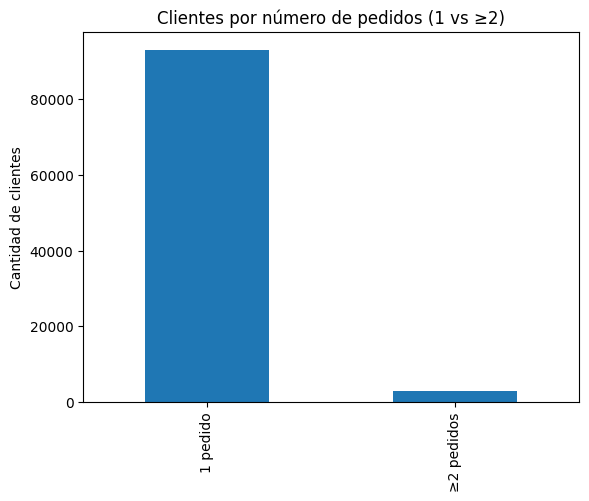

In [12]:
by_cust = orders.groupby('customer_unique_id').size().rename('n_orders')
n_clients = by_cust.shape[0]
n_ge2 = (by_cust >= 2).sum()
print(f"Clientes con ≥2 pedidos: {n_ge2} de {n_clients}  ({n_ge2/n_clients:.2%})")
print(by_cust.describe())

# Gráfico simple: 1 vs ≥2 pedidos
counts = pd.Series({
    "1 pedido": (by_cust==1).sum(),
    "≥2 pedidos": (by_cust>=2).sum(),
})
plt.figure()
counts.plot(kind='bar')
plt.title("Clientes por número de pedidos (1 vs ≥2)")
plt.ylabel("Cantidad de clientes")
plt.xlabel("")
plt.show()

### ⏳ Censura temporal y validez de la etiqueta

- Solo podemos etiquetar un pedido como "recompra en ≤H" si su fecha está al menos **H** días antes del máximo `t` del dataset.  
- Pedidos más recientes que `max(t) - H` quedan **censurados** (no sabemos si habría recompra a tiempo).

In [13]:
H = pd.Timedelta(days=H_DAYS)
max_t = orders['t'].max()
orders['label_valid'] = orders['t'] <= (max_t - H)

valid_rate = orders['label_valid'].mean()
print("Fecha máxima del dataset:", max_t)
print(f"Pedidos con etiqueta válida (t ≤ max_t - H): {valid_rate:.2%}")

# Etiquetado por pedido
orders['next_t'] = orders.groupby('customer_unique_id')['t'].shift(-1)
orders['repeat_in_H'] = ((orders['next_t'] - orders['t']) <= H).astype('float')
orders.loc[orders['next_t'].isna(), 'repeat_in_H'] = 0.0  # si no hay próxima compra, no hay recompra en H
# invalidar etiquetas en censura
orders.loc[~orders['label_valid'], 'repeat_in_H'] = np.nan

# Versión "churn_H" = no hay recompra en ≤H
orders['churn_H'] = (1 - orders['repeat_in_H']).where(orders['repeat_in_H'].notna(), np.nan)

orders_valid = orders[orders['label_valid']].copy()
print("Pedidos válidos para evaluación:", len(orders_valid))
orders_valid[['t','next_t','repeat_in_H','churn_H']].head(5)

Fecha máxima del dataset: 2018-10-17 17:30:18
Pedidos con etiqueta válida (t ≤ max_t - H): 71.66%
Pedidos válidos para evaluación: 71257


,t,next_t,repeat_in_H,churn_H
2,2017-03-10 21:05:03,NaT,0.0,1.0
3,2017-10-12 20:29:41,NaT,0.0,1.0
4,2017-11-14 19:45:42,NaT,0.0,1.0
5,2018-04-05 19:33:16,NaT,0.0,1.0
6,2018-04-20 12:57:23,NaT,0.0,1.0


### ⚖️ Prevalencia y baseline teórico

- Target **repeat_in_H = 1** (segunda compra en ≤H).  
- **Prevalencia** = proporción de 1s en válidos.  
- **Baseline PR-AUC** de un ranking aleatorio = prevalencia.

In [14]:
prev = orders_valid['repeat_in_H'].mean()
print(f"Prevalencia repeat_in_H (válidos): {prev:.4f} ({prev:.2%})")
print(f"Baseline PR-AUC (azar): {prev:.4f}")

# Cotas para Precision@k y Lift@k bajo *ranking perfecto*
def precision_upper_bound(prevalence, k_frac):
    # En el mejor de los casos, todo lo positivo cae arriba
    # Precision@k = min(1, prevalence / k_frac) si k_frac <= 1
    return min(1.0, prevalence / k_frac)

for k in (0.1, 0.2):
    p_up = precision_upper_bound(prev, k)
    lift_up = p_up / prev if prev > 0 else float('inf')
    print(f"k={int(k*100)}% -> Precision@k (cota superior): {p_up:.3f} | Lift@k máx.: {lift_up:.2f}x")

Prevalencia repeat_in_H (válidos): 0.0331 (3.31%)
Baseline PR-AUC (azar): 0.0331
k=10% -> Precision@k (cota superior): 0.331 | Lift@k máx.: 10.00x
k=20% -> Precision@k (cota superior): 0.165 | Lift@k máx.: 5.00x


### 🧾 Resumen y recomendación

- **% clientes con ≥2 compras** bajo (poca señal).  
- **Censura** reduce aún más los ejemplos válidos para etiquetar.  
- **Prevalencia** de *repeat_in_H* baja ⇒ **PR-AUC base** muy baja.  
- Para **churn real**, faltan datos de CRM/exposición/estado de baja.